In [ ]:
import os, sys

proj_dir = '/content/drive/MyDrive/Colab Notebooks/Text2Struct/'
print(os.path.exists(proj_dir))

modules_dir = proj_dir + 'modules/'
sys.path.insert(0, modules_dir)

# data_dir = proj_dir + 'dataset/annotated/thrombectomy_0-99/'
data_dir = proj_dir + 'dataset/combined/'
workspace = proj_dir + 'rnn/'

True


In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, RepeatVector, TimeDistributed, Dropout, GRU, Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model

2.9.2


In [ ]:
file = open(data_dir + "corpus_examples_num_proc.pkl", 'rb')
corpus_examples = pickle.load(file)
file.close()

# Text Segmentation

In [ ]:
# n = np.random.choice(len(corpus_examples))
# print(n)
# example = corpus_examples[n]
# example

In [ ]:
# text = example['text'].copy()
# label = example['label'].copy()
# numLab = example['numLab'].copy()
# num_idx = example['num_idx'].copy()
# unit_idx = example['unit_idx'].copy()
# targ_idx = example['targ_idx'].copy()

# # numLab = np.zeros((len(text),), dtype=int)
# # numLab[num_idx] = 1

# print('Num is:', text[num_idx])
# print('Unit is:', text[unit_idx])
# print('Targ is:', text[targ_idx])

# print()
# print('Num is:', text[numLab == 1])
# print('Unit is:', text[label == 1])
# print('Targ is:', text[label == 2])

In [ ]:
# idx = num_idx + unit_idx + targ_idx
# min_idx = min(idx)
# max_idx = max(idx)
# rng_idx = max_idx - min_idx
# min_idx, max_idx, rng_idx

In [ ]:
# ## Method 1
# window_size = 50

# print(min_idx, max_idx)
# print([*range(min_idx-(window_size-rng_idx), min_idx+1)])
# min_sel = max(random.randrange(min_idx-(window_size-rng_idx), min_idx+1), 0)
# min_sel

# text_new = text[min_sel:(min_sel + window_size)]
# label_new = label[min_sel:(min_sel + window_size)]
# numLab_new = numLab[min_sel:(min_sel + window_size)]
# num_idx_new = [idx - min_sel for idx in num_idx]
# unit_idx_new = [idx - min_sel for idx in unit_idx]
# targ_idx_new = [idx - min_sel for idx in targ_idx]

# print('Num is:', text_new[numLab_new == 1])
# print('Unit is:', text_new[label_new == 1])
# print('Targ is:', text_new[label_new == 2])

In [ ]:
# ## Method 2
# del_idx = 5
# lb_idx = max(min_idx-del_idx, 0)
# ub_idx = min(max_idx+del_idx+1, len(text))
# text_new = text[lb_idx:ub_idx]
# label_new = label[lb_idx:ub_idx]
# numLab_new = numLab[lb_idx:ub_idx]

# print('Text is:', text_new)
# print('Num is:', text_new[numLab_new == 1])
# print('Unit is:', text_new[label_new == 1])
# print('Targ is:', text_new[label_new == 2])

In [ ]:
def segment_on_example(example):
  text = example['text'].copy()
  label = example['label'].copy()
  numLab = example['numLab'].copy()

  num_idx = example['num_idx'].copy()
  unit_idx = example['unit_idx'].copy()
  targ_idx = example['targ_idx'].copy()

  idx = num_idx + unit_idx + targ_idx
  min_idx = min(idx)
  max_idx = max(idx)

  del_idx = 5
  lb_idx = max(min_idx-del_idx, 0)
  ub_idx = min(max_idx+del_idx+1, len(text))
  text_new = text[lb_idx:ub_idx]
  label_new = label[lb_idx:ub_idx]
  numLab_new = numLab[lb_idx:ub_idx]

  return text_new, label_new, numLab_new

In [ ]:
# text_new, label_new, numLab_new = segment_on_example(example)

# print('Text is:', text_new)
# print('Num is:', text_new[numLab_new == 1])
# print('Unit is:', text_new[label_new == 1])
# print('Targ is:', text_new[label_new == 2])

In [ ]:
text_chunks = []
label_chunks = []
numLab_chunks = []
max_len = 0

for example in corpus_examples:
  text_new, label_new, numLab_new = segment_on_example(example)
  text_chunks.append(text_new)
  label_chunks.append(label_new)
  numLab_chunks.append(numLab_new)
  if len(text_new) > max_len: max_len = len(text_new)

print(max_len)

48


In [ ]:
n = np.random.choice(len(text_chunks))
print(n)

text_new = text_chunks[n]
label_new = label_chunks[n]
numLab_new = numLab_chunks[n]

print('Text is:', text_new)
print('Num is:', text_new[numLab_new == 1])
print('Unit is:', text_new[label_new == 1])
print('Targ is:', text_new[label_new == 2])

1513
Text is: ['median' 'NIHSS' 'was' '[num]' '(' 'IQR' '[num]' '-' '2' '7' '[dot]' '0'
 ')' '.']
Num is: ['2' '7' '[dot]' '0']
Unit is: []
Targ is: ['IQR']


# Training/Tesing Data

In [ ]:
def create_character_tokenizer(list_of_strings):  # list_of_strings has batch_size
    """
    This function takes a list of strings as its argument. It should create 
    and return a Tokenizer according to the above specifications. 
    """
    
    tokenizer = Tokenizer(num_words=None, 
                          filters=None,
                          lower=False,
                          char_level=False,  # why
                          oov_token='[oov]',
                          document_count=0)
    tokenizer.fit_on_texts(list_of_strings)
    return tokenizer

In [ ]:
# tokenizer = create_character_tokenizer(text_chunks)

text_list = [list(t) for t in text_chunks]
tokenizer = create_character_tokenizer(text_list)

tokenizer.index_word;

In [ ]:
def strings_to_sequences(tokenizer, list_of_strings):  # list_of_strings has batch_size
    """
    This function takes a tokenizer object and a list of strings as its arguments.
    It should use the tokenizer to map the text chunks to sequences of tokens and
    then return this list of encoded sequences.
    """
    
    sequence_chunks = tokenizer.texts_to_sequences(list_of_strings)
    return sequence_chunks

In [ ]:
# strings_to_sequences(tokenizer, [text_list[0]])

In [ ]:
seq_list = []
for text in text_list:
  seq_list += strings_to_sequences(tokenizer, [text])

In [ ]:
n = np.random.choice(len(text_list))
print(text_list[n])
# print(seq_list[n])
print( [tokenizer.index_word[i] for i in seq_list[n]] )

['odds', 'ratio', 'was', '[num]', '(', '[num]', 'CI', ',', '[num]', '-', '1', '[dot]', '4', '3', ')', 'with', 'thrombectomy', 'alone', 'compared']
['odds', 'ratio', 'was', '[num]', '(', '[num]', 'CI', ',', '[num]', '-', '1', '[dot]', '4', '3', ')', 'with', 'thrombectomy', 'alone', 'compared']


In [ ]:
def make_padded_dataset(sequence_chunks):
    """
    This function takes a list of lists of tokenized sequences, and transforms
    them into a 2D numpy array, padding the sequences as necessary according to
    the above specification. The function should then return the numpy array.
    """
    
    padded_sequences = pad_sequences(sequence_chunks,
                                     maxlen=50,
                                     padding='pre',
                                     truncating='post',
                                     value=0)
    return padded_sequences

In [ ]:
pad_seq_chunks = make_padded_dataset(seq_list)
pad_label_chunks = make_padded_dataset(label_chunks)
pad_numLab_chunks = make_padded_dataset(numLab_chunks)

In [ ]:
n = np.random.choice(pad_seq_chunks.shape[0])
print(text_list[n])
print( [tokenizer.index_word[i] for i in pad_seq_chunks[n] if i != 0] )

['analysis', 'after', 'two-thirds', 'of', 'the', 'sample', 'size', '(', '2', '1', '2', '[dot]', '0', 'patients', ')', 'have', 'achieved', 'the', '[num]']
['analysis', 'after', 'two-thirds', 'of', 'the', 'sample', 'size', '(', '2', '1', '2', '[dot]', '0', 'patients', ')', 'have', 'achieved', 'the', '[num]']


In [ ]:
# print(pad_label_chunks[n])
# print(pad_numLab_chunks[n])

In [ ]:
label_new = pad_label_chunks[n][pad_seq_chunks[n] != 0]
print('Unit is:', np.array(text_list[n])[label_new==1])
print('Targ is', np.array(text_list[n])[label_new==2])

Unit is: ['patients']
Targ is ['sample' 'size']


In [ ]:
numLab_new = pad_numLab_chunks[n][pad_seq_chunks[n] != 0]
print('Num is:', np.array(text_list[n])[numLab_new==1])

Num is: ['2' '1' '2' '[dot]' '0']


# Training

In [ ]:
x_train, x_test, y_train, y_test, nl_train, nl_test = \
    train_test_split(pad_seq_chunks, pad_label_chunks, pad_numLab_chunks, test_size = 0.1)

In [ ]:
x_train.shape, x_test.shape

((1582, 50), (176, 50))

In [ ]:
## Checking
n = np.random.choice(x_train.shape[0])
# n = 0

seq = x_train[n][x_train[n] != 0]
label = y_train[n][x_train[n] != 0]
nl = nl_train[n][x_train[n] != 0]

text = np.array([tokenizer.index_word[i] for i in seq])
print('Text is:', text)
num = text[nl == 1]
print('Num is:', num)
unit = text[label == 1]
print('Unit is:', unit)
targ = text[label == 2]
print('Targ is:', targ)

Text is: [':' '[num]' '-' '[num]' ';' 'thrombectomy' ':' '[num]' '-' '2' '0' '1'
 '9' '[dot]' '0' ')' '.']
Num is: ['2' '0' '1' '9' '[dot]' '0']
Unit is: []
Targ is: ['thrombectomy']


In [ ]:
def model_create(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.003
    batch_size = 32

    # Build the layers    
    model = Sequential()
    # Embedding
    model.add(Embedding(input_dim=english_vocab_size, 
                        output_dim=128, 
                        # input_length=input_shape[1],
                        # input_shape=input_shape[1:], 
                        # batch_input_shape=(batch_size, None),
                        mask_zero=True
                        ))
    # Encoder
    model.add(Bidirectional(GRU(128)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))

    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [ ]:
model = model_create(input_shape=x_train.shape[1], 
                     output_sequence_length=y_train.shape[1], 
                     english_vocab_size=len(tokenizer.index_word), 
                     french_vocab_size=3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         156672    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 50, 256)          0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 256)          296448    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 50, 512)          131584    
 ibuted)                                                

In [ ]:
# x_train[0:1]
# model.predict(x_train[:32]).shape

In [ ]:
# y_train[0:1]
# y_train.shape
# tf.one_hot(y_train, 3).shape

In [ ]:
# model.evaluate(x_train[1:2], y_train[1:2])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=20, 
                    batch_size=32,
                    callbacks = [early_stopping])

Epoch 1/20
50/50 [==============================] - 22s 251ms/step - loss: 0.2686 - accuracy: 0.9472 - val_loss: 0.1939 - val_accuracy: 0.9558
Epoch 2/20
50/50 [==============================] - 14s 275ms/step - loss: 0.1773 - accuracy: 0.9536 - val_loss: 0.1397 - val_accuracy: 0.9558
Epoch 3/20
50/50 [==============================] - 13s 258ms/step - loss: 0.1439 - accuracy: 0.9533 - val_loss: 0.1339 - val_accuracy: 0.9558
Epoch 4/20
50/50 [==============================] - 13s 259ms/step - loss: 0.1298 - accuracy: 0.9535 - val_loss: 0.1167 - val_accuracy: 0.9564
Epoch 5/20
50/50 [==============================] - 12s 240ms/step - loss: 0.1205 - accuracy: 0.9545 - val_loss: 0.1009 - val_accuracy: 0.9570
Epoch 6/20
50/50 [==============================] - 12s 242ms/step - loss: 0.1025 - accuracy: 0.9589 - val_loss: 0.0965 - val_accuracy: 0.9589
Epoch 7/20
50/50 [==============================] - 12s 241ms/step - loss: 0.0880 - accuracy: 0.9633 - val_loss: 0.0858 - val_accuracy: 0.9651

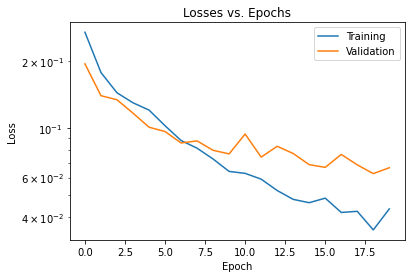

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Losses vs. Epochs')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
p_test = model.predict(x_test)
p_test.shape
# p_test[0]

6/6 [==============================] - 0s 30ms/step


(176, 50, 3)

In [ ]:
i_test = tf.argmax(p_test, axis=-1)
i_test.shape
# i_test[0]

TensorShape([176, 50])

In [ ]:
# y_test[0]

In [ ]:
# len(x_test)

In [ ]:
n = np.random.choice(len(x_test))
print(n)

seq = x_test[n][x_test[n] != 0]
label = y_test[n][x_test[n] != 0]
nl = nl_test[n][x_test[n] != 0]

text = np.array([tokenizer.index_word[i] for i in seq])

print('Text is:', text)
num = text[nl == 1]
print('Num is:', num)

print('---Truth---')
unit = text[label == 1]
print('Unit is:', unit)
targ = text[label == 2]
print('Targ is:', targ)

print('---Pred---')
label_pred = i_test[n][x_test[n] != 0].numpy()
# print(label_pred)
unit_pred = text[label_pred == 1]
print('Unit is:', unit_pred)
targ_pred = text[label_pred == 2]
print('Targ is:', targ_pred)

143
Text is: ['[num]' ')' ',' 'followed' 'by' 'cardioembolism' '(' '0' '[dot]' '1' '6'
 '3' ')' '.']
Num is: ['0' '[dot]' '1' '6' '3']
---Truth---
Unit is: []
Targ is: ['cardioembolism']
---Pred---
Unit is: []
Targ is: ['cardioembolism']


In [ ]:
## Save model
model.save(workspace + 'current_model.h5')

In [ ]:
## Save data
current_data_dir = workspace + 'current_data/'

if not os.path.exists(current_data_dir):
    os.makedirs(current_data_dir)

filehandler = open(current_data_dir + "index_word.pkl", "wb")
pickle.dump(tokenizer.index_word, filehandler)
filehandler.close()

filehandler = open(current_data_dir + "word_index.pkl", "wb")
pickle.dump(tokenizer.word_index, filehandler)
filehandler.close()

filehandler = open(current_data_dir + "x_train.pkl", "wb")
pickle.dump(x_train, filehandler)
filehandler.close()

filehandler = open(current_data_dir + "y_train.pkl", "wb")
pickle.dump(y_train, filehandler)
filehandler.close()

filehandler = open(current_data_dir + "nl_train.pkl", "wb")
pickle.dump(nl_train, filehandler)
filehandler.close()

filehandler = open(current_data_dir + "x_test.pkl", "wb")
pickle.dump(x_test, filehandler)
filehandler.close()

filehandler = open(current_data_dir + "y_test.pkl", "wb")
pickle.dump(y_test, filehandler)
filehandler.close()

filehandler = open(current_data_dir + "nl_test.pkl", "wb")
pickle.dump(nl_test, filehandler)
filehandler.close()

In [ ]:
## Testing: Load Model
if 'model' in globals():
    del model

model = load_model(workspace + 'current_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         156672    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 repeat_vector_1 (RepeatVect  (None, 50, 256)          0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 256)          296448    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 512)          131584    
 tributed)                                            